import libraries

In [37]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import joblib

import dataset and print how many rows are included


In [38]:
df = pd.read_csv("../../data/Salary_Data.csv")
print("Rows after loading:", len(df))


Rows after loading: 6704


This code removes all rows with missing values and then prints the number of rows left in the dataset.

In [39]:
df.dropna(inplace=True)
print("Rows after removing NA:", len(df))

Rows after removing NA: 6698


This code tidies up the education data by fixing formatting and spelling, removes any duplicate entries, and then shows how many rows are left.



In [40]:
def clean_text(text):
    if isinstance(text, str):
        text = text.strip().lower()
        text = text.replace("’", "'")
        text = text.replace(" degree", "")
        text = text.replace("bachelors", "bachelor's")
        text = text.replace("masters", "master's")
    return text

df['Education Level'] = df['Education Level'].apply(clean_text)
df.drop_duplicates(inplace=True)
print("Rows after removing duplicates:", len(df))

Rows after removing duplicates: 1786


This code removes extreme salary values using the IQR method, filters out salaries below 1000, resets the row numbers, and then shows how many rows remain.

In [41]:
def remove_outliers_iqr(df, cols):
    for col in cols:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        df = df[(df[col] >= Q1 - 1.5*IQR) & (df[col] <= Q3 + 1.5*IQR)]
    return df

df_clean = remove_outliers_iqr(df, ['Salary'])
df_clean = df_clean[df_clean['Salary'] > 1000]
df_clean = df_clean.reset_index(drop=True)
print("Rows after cleaning:", len(df_clean))

Rows after cleaning: 1782


This code separates the data into inputs and the salary we want to predict, then splits it so the model can learn from most of the data while keeping a small portion aside for testing, making sure the gender balance stays the same in both sets.

In [42]:
X = df_clean.drop('Salary', axis=1)
y = df_clean['Salary']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=X['Gender']
)

In [43]:
threshold = 10
for col in ['Job Title', 'Education Level']:
    top_categories = X_train[col].value_counts().loc[lambda x: x >= threshold].index
    X_train[col] = X_train[col].where(X_train[col].isin(top_categories), 'Other')
    X_test[col] = X_test[col].where(X_test[col].isin(top_categories), 'Other')



numerical_cols = ['Age', 'Years of Experience']
categorical_cols = ['Gender', 'Education Level', 'Job Title']

preprocessor = ColumnTransformer(transformers=[
    ('num', StandardScaler(), numerical_cols),
    ('cat', OneHotEncoder(drop='first', handle_unknown='ignore'), categorical_cols)
])

This code cleans up rare job titles and education levels, separates numbers from categories, and prepares the data so the model can understand it properly.

In [44]:
knn_model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', KNeighborsRegressor(
        n_neighbors=7,
        weights='distance',  # distance-based improves performance
        metric='minkowski',
        p=2
    ))
])


This code tests how well your KNN model performs by splitting the training data into 5 parts, training and validating on each part, then shows the average prediction accuracy and how much it varies.

In [45]:
kfold = KFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = cross_val_score(knn_model, X_train, y_train, cv=kfold, scoring='r2')
print(f"\nMean CV R²: {cv_scores.mean():.3f} (+/- {cv_scores.std() * 2:.3f})")


Mean CV R²: 0.876 (+/- 0.020)


This code teaches the KNN model from the training data, then uses it to guess salaries for both the data it has seen (training) and new data (testing).

In [46]:
knn_model.fit(X_train, y_train)

# Predictions
y_train_pred = knn_model.predict(X_train)
y_test_pred = knn_model.predict(X_test)

This code checks how close the KNN model’s predicted salaries are to the actual salaries, prints the results, and shows a scatter plot comparing predicted vs actual salaries.
For training data and testing data, it shows

RMSE: Average size of errors in LKR (lower is better)
R²: How well the model explains salary differences (closer to 1 is better)
MAE: Average absolute error in LKR


Training Metrics:
RMSE: LKR 5,063.45
R²: 0.990
MAE: LKR 1,631.91

Testing Metrics:
RMSE: LKR 18,425.01
R²: 0.878
MAE: LKR 12,525.33


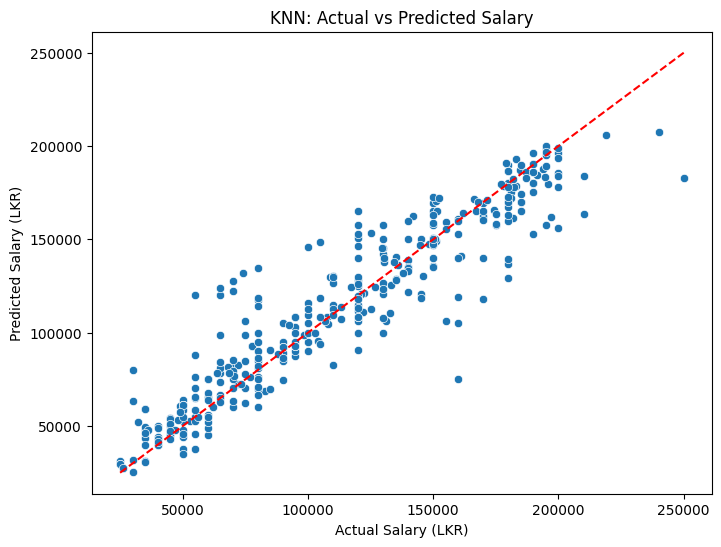

In [47]:
def evaluate_detailed(y_true, y_pred, name):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    print(f"\n{name} Metrics:")
    print(f"RMSE: LKR {rmse:,.2f}")
    print(f"R²: {r2:.3f}")
    print(f"MAE: LKR {mae:,.2f}")
    return rmse, r2, mae

evaluate_detailed(y_train, y_train_pred, "Training")
evaluate_detailed(y_test, y_test_pred, "Testing")


plt.figure(figsize=(8,6))
sns.scatterplot(x=y_test, y=y_test_pred)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel("Actual Salary (LKR)")
plt.ylabel("Predicted Salary (LKR)")
plt.title("KNN: Actual vs Predicted Salary")
plt.show()

This code predicts the salary for a new employee and saves the trained KNN model so it can be used again later without retraining.

In [48]:
new_employee = pd.DataFrame({
    'Age': [40],
    'Years of Experience': [5],
    'Gender': ['Male'],
    'Education Level': ['bachelor'],
    'Job Title': ['Data Analyst']
})

predicted_salary = knn_model.predict(new_employee)[0]
print(f"\nPredicted Salary (KNN): LKR {predicted_salary:,.2f}")



joblib.dump(knn_model, "KNN_salary_model.pkl")
print("\nModel saved as KNN_salary_model.pkl")


Predicted Salary (KNN): LKR 161,998.59

Model saved as KNN_salary_model.pkl


/opt/conda/envs/ml-env/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
